In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from jax.scipy.special import erf
import jax.random as random
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import jax
import numpy as np
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 4.9 MB/s eta 0:00:00


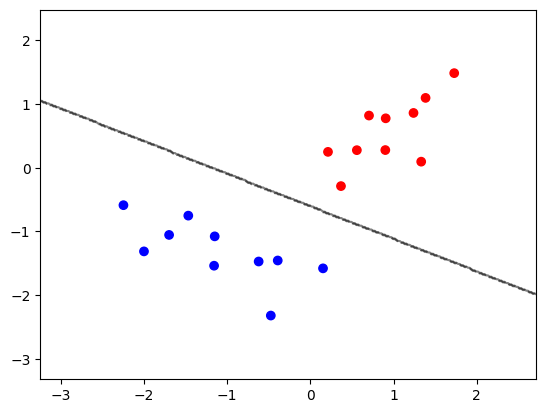

In [13]:
# Generate random points following the Gaussian distributions for the source
mean1 = jnp.array([1, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([-1, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10

def Generate2DDataset(mean1, cov1, mean2, cov2,n1 = 10,  n2 = 10, randomkey =1):
  key = random.PRNGKey(1)
  x1 = random.multivariate_normal(key, mean1, cov1, (n1,))
  x2 = random.multivariate_normal(key, mean2, cov2, (n2,))
  X = jnp.concatenate([x1, x2])
  y = jnp.concatenate([jnp.ones((n1,)), -jnp.ones((n2,))])
  return x1,x2,X,y

x1,x2,X,y = Generate2DDataset(mean1, cov1, mean2, cov2,n1, n2)


def makeSVM(X,y, kernel = 'linear') :
  svm = SVC(kernel=kernel)
  svm.fit(X, y)
  return svm

svm = makeSVM(X,y)

# Plot the data and the decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.show()

In [14]:
# Generate random points following the Gaussian distributions for target 
mean1 = jnp.array([3, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([2, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1_=10
n2_=10
x1_,x2_,X_,y_ = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_)

In [7]:
# Plotting utility
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

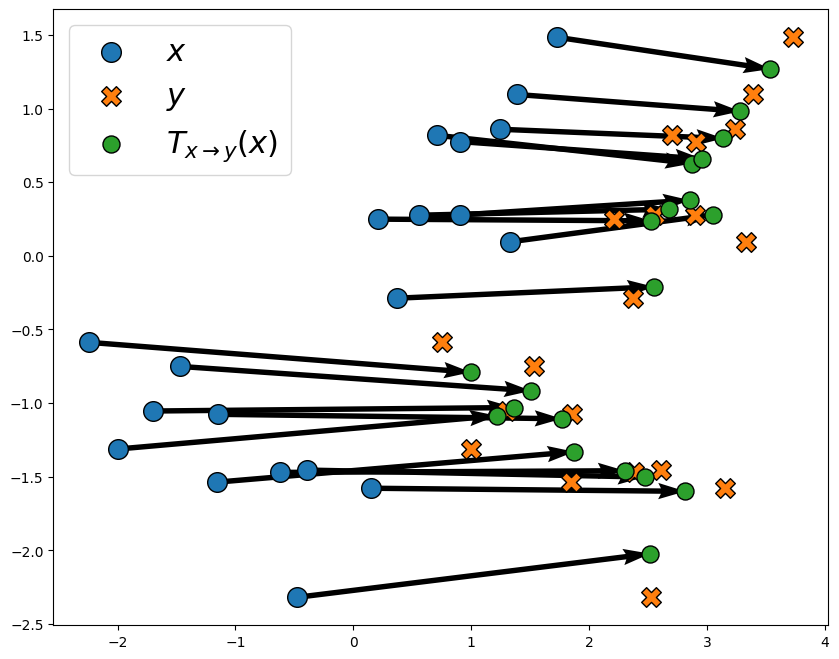

In [15]:
def getTransport(X, X_, cost_fn = costs.SqEuclidean(), plot = True):
  geom = pointcloud.PointCloud(X, X_, cost_fn=cost_fn) # l'argument cost_fn permet de changer la fonction coût ici
  out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
  dual_potentials = out.to_dual_potentials()
  if plot == True and len(X[0])==2 and len(X_[0]) == 2:
    plot_map(X, X_, dual_potentials.transport(X))
   
  return dual_potentials.transport(X)

tX = getTransport(X,X_)

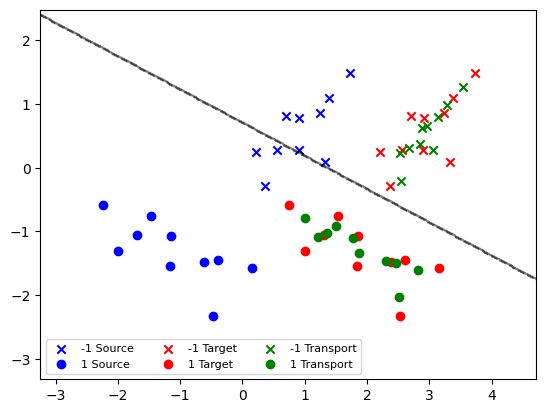

In [16]:
svm = makeSVM(tX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(tX[:,0][:n1], tX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(tX[:,0][n1:], tX[:,1][n1:], marker='o', color=colors[2])
# plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
# plt.scatter(X_[:,0], X_[:,1], c=y_, cmap='PiYG')
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport', '1 Transport'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

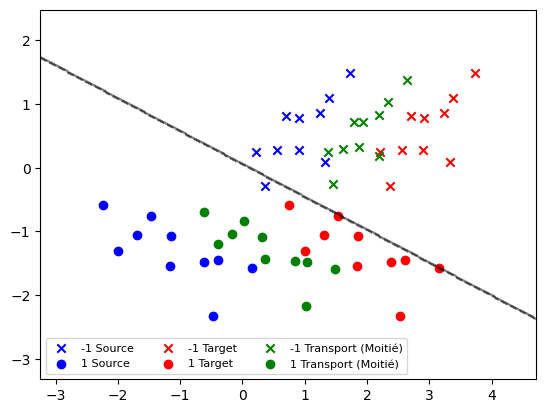

In [18]:
# We plot the boundary decision made for the middle of the transportation plan :
meanX = (tX+X)/2
svm = makeSVM(meanX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(meanX[:,0][:n1], meanX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(meanX[:,0][n1:], meanX[:,1][n1:], marker='o', color=colors[2])
# plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
# plt.scatter(X_[:,0], X_[:,1], c=y_, cmap='PiYG')
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport (Moitié)', '1 Transport (Moitié)'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

In [21]:
from sklearn.ensemble import VotingClassifier
step = 10

def votingclassifier(X,y, tX,step = 10, longtrain = True):
  svm0 = makeSVM(X,y)
  X_t = X
  y_t = y
  if longtrain ==False or longtrain =='both':
    X_t2 = jnp.concatenate([X, tX])
    y_t2 = jnp.concatenate([y, y])
  svm = [svm0]
  for i in range(1, step+1):
    newX = ((step-i)/step)*X + (i/step)*tX
    X_t = jnp.concatenate([X_t, newX])
    y_t = jnp.concatenate([y_t, y])
    svm.append(makeSVM(newX,y))

  estimator = []
  for i in range(len(svm)):
    estimator.append((str(i), svm[i]))
  # Create voting ensemble of SVM linear classifiers
  ensemble = VotingClassifier(estimators=estimator, voting='hard')

  # Fit the ensemble on the training data
  if longtrain == False :
    ensemble.fit(X_t2, y_t2)
    return ensemble
  elif longtrain == 'both':
    return ensemble.fit(X_t,y_t), ensemble.fit(X_t2,y_t2)
  else : 
    return ensemble.fit(X_t,y_t)

ensemble1, ensemble2 = votingclassifier(X,y,tX, step, longtrain = 'both')

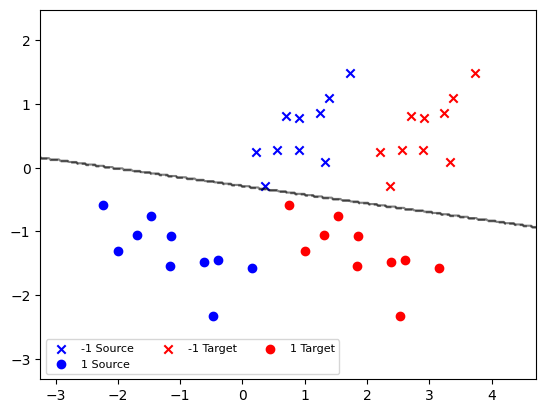

In [23]:
# Plot with the training on all the intermediary steps of the transport plan

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
# plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
# plt.scatter(X_[:,0], X_[:,1], c=y_, cmap='PiYG')
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

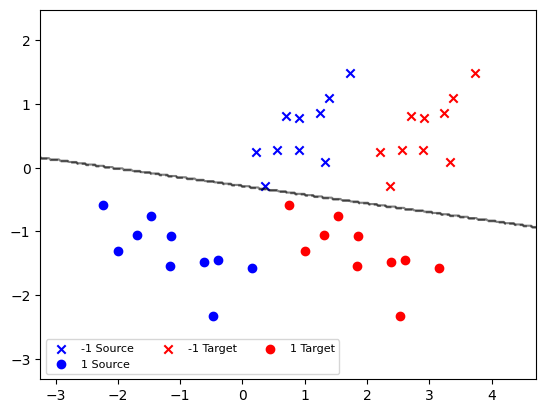

In [24]:
# Plot with the training on the orignal and the transported points

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
# plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
# plt.scatter(X_[:,0], X_[:,1], c=y_, cmap='PiYG')
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

La différence est minime car les données sont suffisament séparées.

# Caltech Office Dataset

In [3]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
download_and_unzip('https://github.com/mdlbm/Optimal-Transport-Domain-Adaptation/raw/main/data/decaf6.zip')


In [28]:
import os, sys, traceback
import matplotlib.pylab as pylab
import numpy as np
import pylab as pl
from scipy.io import loadmat
from scipy.stats.mstats import zscore
# Four domains: { Caltech10, amazon, webcam, dslr }
possible_DTS = ['caltech', 'amazon', 'webcam', 'dslr']

tests = []
data = {}

for ds in possible_DTS:
    if "google.colab" in sys.modules:
      path = '/content/'+ds+'_decaf.mat'
    else :
      path = ds+'_decaf.mat'
    possible_data = loadmat(path)
    feat = possible_data['feas'].astype(float)
    labels = possible_data['labels']
    data[ds]=[feat,labels]


In [70]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['caltech'][0], data['caltech'][1], test_size=0.1, random_state=42)

# Define the neural network model
model = MLPClassifier(hidden_layer_sizes=(8192,), max_iter=500, alpha=0.01,
                      solver='sgd', verbose=10, random_state=42,
                      learning_rate_init=0.1)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 23.02449881
Iteration 2, loss = 1361.20078627
Iteration 3, loss = 877460.17365629
Iteration 4, loss = 18149310.25270613
Iteration 5, loss = 62412126.64571945
Iteration 6, loss = 99227653.34415349
Iteration 7, loss = 122466566.54041953
Iteration 8, loss = 135728095.45843756
Iteration 9, loss = 142906006.46134025
Iteration 10, loss = 146630230.30781305
Iteration 11, loss = 148457010.53613898
Iteration 12, loss = 149258235.63113102
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.48672566371681414


In [73]:
# Transport one dataset to another :

def DataTransport(dataset1, dataset2, hidden_size = 4096):
  trX = getTransport(data[dataset1][0], data[dataset2][0])
  # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=500, alpha=0.01,
                        solver='sgd', verbose=10, random_state=42,
                        learning_rate_init=0.1)

  # Train the model
  model.fit(trX, data[dataset1][1])

  # Evaluate the model on the test set
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  print("Accuracy:", accuracy)
  return model

In [74]:
for i in possible_DTS:
  for j in possible_DTS:
    if i != j: 
      print('Accuracy result from {} to {} :'.format(i,j))
      DataTransport(i,j)

      

Accuracy result from caltech to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 46.80579969
Iteration 2, loss = 37992.92704519
Iteration 3, loss = 34768615.91888478
Iteration 4, loss = 249029472.39372209
Iteration 5, loss = 474113429.67585689
Iteration 6, loss = 625506465.29343486
Iteration 7, loss = 714757164.25311518
Iteration 8, loss = 764489594.88840258
Iteration 9, loss = 791386124.76830924
Iteration 10, loss = 805628410.55258715
Iteration 11, loss = 812999548.47691596
Iteration 12, loss = 816677797.60540688
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.19728601252609604
Accuracy result from caltech to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 23.89081895
Iteration 2, loss = 21282.67407314
Iteration 3, loss = 112379.20987495
Iteration 4, loss = 203920.05515054
Iteration 5, loss = 266836.49088608
Iteration 6, loss = 304238.98283623
Iteration 7, loss = 325163.04837861
Iteration 8, loss = 336500.13152622
Iteration 9, loss = 342508.56491857
Iteration 10, loss = 345619.28189555
Iteration 11, loss = 347171.02945914
Iteration 12, loss = 347889.70850045
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.17627118644067796
Accuracy result from caltech to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 18.97704509
Iteration 2, loss = 6776.22227800
Iteration 3, loss = 99428.75095414
Iteration 4, loss = 348089.74759176
Iteration 5, loss = 589936.58510166
Iteration 6, loss = 750196.73173905
Iteration 7, loss = 844117.67199277
Iteration 8, loss = 896290.81671003
Iteration 9, loss = 924441.05646896
Iteration 10, loss = 939308.24941632
Iteration 11, loss = 946970.05675142
Iteration 12, loss = 950761.20813194
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.08917197452229299
Accuracy result from amazon to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 15.94424816
Iteration 2, loss = 987.18581433
Iteration 3, loss = 32285.04958247
Iteration 4, loss = 90082.92856090
Iteration 5, loss = 139740.45582294
Iteration 6, loss = 174457.31988482
Iteration 7, loss = 196801.18061598
Iteration 8, loss = 210609.07291456
Iteration 9, loss = 218943.44792959
Iteration 10, loss = 223895.30159649
Iteration 11, loss = 226797.69107536
Iteration 12, loss = 228471.50443377
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.3098842386464826
Accuracy result from amazon to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 14.20050589
Iteration 2, loss = 97.82866064
Iteration 3, loss = 1407.38764280
Iteration 4, loss = 4480.66145770
Iteration 5, loss = 8539.95341497
Iteration 6, loss = 11964.26581682
Iteration 7, loss = 14344.17057125
Iteration 8, loss = 15871.50059784
Iteration 9, loss = 16813.51956010
Iteration 10, loss = 17381.18330888
Iteration 11, loss = 17717.77713097
Iteration 12, loss = 17914.47141426
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.20677966101694914
Accuracy result from amazon to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 12.99671683
Iteration 2, loss = 1272.88480829
Iteration 3, loss = 131425.22188852
Iteration 4, loss = 496114.44079345
Iteration 5, loss = 839684.39056415
Iteration 6, loss = 1087907.72577820
Iteration 7, loss = 1250090.61934388
Iteration 8, loss = 1351088.63093484
Iteration 9, loss = 1412342.72473520
Iteration 10, loss = 1448863.21933186
Iteration 11, loss = 1470339.07703635
Iteration 12, loss = 1482780.04872386
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.17834394904458598
Accuracy result from webcam to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.44767124
Iteration 2, loss = 15.83744158
Iteration 3, loss = 36.75965671
Iteration 4, loss = 423.40443455
Iteration 5, loss = 1523.71386331
Iteration 6, loss = 3532.37643826
Iteration 7, loss = 6392.98640236
Iteration 8, loss = 10432.47939680
Iteration 9, loss = 14767.15797420
Iteration 10, loss = 19017.76506205
Iteration 11, loss = 22943.90852782
Iteration 12, loss = 26440.23944945
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.19145146927871773
Accuracy result from webcam to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.97681119
Iteration 2, loss = 18.32876990
Iteration 3, loss = 43.41992886
Iteration 4, loss = 316.18564801
Iteration 5, loss = 9015.97744885
Iteration 6, loss = 26008.84842701
Iteration 7, loss = 98776.45644914
Iteration 8, loss = 203314.52322367
Iteration 9, loss = 320282.47524281
Iteration 10, loss = 436240.16455202
Iteration 11, loss = 544064.37624357
Iteration 12, loss = 640498.92132438
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.1837160751565762
Accuracy result from webcam to dslr :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 8.83544651
Iteration 2, loss = 14.30682781
Iteration 3, loss = 24.98727102
Iteration 4, loss = 886.31743959
Iteration 5, loss = 6597.63931667
Iteration 6, loss = 15838.20163265
Iteration 7, loss = 35790.93436715
Iteration 8, loss = 272718.64533577
Iteration 9, loss = 4910256.25032677
Iteration 10, loss = 15884207.80887714
Iteration 11, loss = 29846572.64259830
Iteration 12, loss = 44657090.81601046
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.3885350318471338
Accuracy result from dslr to caltech :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 5.02535256
Iteration 2, loss = 12.62909840
Iteration 3, loss = 14.51697990
Iteration 4, loss = 25.49787974
Iteration 5, loss = 41.70897644
Iteration 6, loss = 61.33661885
Iteration 7, loss = 84.58215627
Iteration 8, loss = 344.72733815
Iteration 9, loss = 4273.60676658
Iteration 10, loss = 9698.91506083
Iteration 11, loss = 16129.23439354
Iteration 12, loss = 23796.50830924
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.11398040961709706
Accuracy result from dslr to amazon :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 5.61519515
Iteration 2, loss = 13.95249769
Iteration 3, loss = 15.52530479
Iteration 4, loss = 57.13464253
Iteration 5, loss = 112.09316991
Iteration 6, loss = 202.27043106
Iteration 7, loss = 373.99962517
Iteration 8, loss = 3520.32694131
Iteration 9, loss = 35120.06806485
Iteration 10, loss = 225262.93098440
Iteration 11, loss = 436807.80982273
Iteration 12, loss = 685949.90372325
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.32150313152400833
Accuracy result from dslr to webcam :


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 7.06456318
Iteration 2, loss = 12.26285519
Iteration 3, loss = 12.32082765
Iteration 4, loss = 17.30385811
Iteration 5, loss = 24.14760282
Iteration 6, loss = 34.04251847
Iteration 7, loss = 45.22190069
Iteration 8, loss = 65.86544468
Iteration 9, loss = 85.81185864
Iteration 10, loss = 123.17206615
Iteration 11, loss = 217.14455221
Iteration 12, loss = 342.65777499
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.44745762711864406
